# Input & Label

In [1]:
from rtmag.paper.load import load_input_label, MyModel

In [2]:
input_files, label_files = load_input_label("/mnt/f/isee_dataset/11158")
len(input_files), len(label_files)

(66, 66)

In [3]:
idx = 13
input_files[idx]

PosixPath('/mnt/f/isee_dataset/11158/input/input_11158_20110214_000000.npz')

In [4]:
from sunpy.map import Map
from skimage.transform import resize
import matplotlib.pyplot as plt
import astropy.units as u

In [5]:
hmi_Br_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/hmi/hmi.sharp_cea_720s.377.20110214_000000_TAI.Br.fits")

See https://docs.sunpy.org/en/stable/code_ref/map.html#fixing-map-metadata for how to fix metadata before loading it with sunpy.map.Map.
See https://fits.gsfc.nasa.gov/fits_standard.html for the FITS unit standards. [sunpy.map.mapbase]


In [6]:
aia_94_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/94/aia.lev1_euv_12s.2011-02-14T000004Z.94.image_lev1.fits")
aia_131_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/131/aia.lev1_euv_12s.2011-02-14T000011Z.131.image_lev1.fits")
aia_171_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/171/aia.lev1_euv_12s.2011-02-14T000001Z.171.image_lev1.fits")
aia_193_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/193/aia.lev1_euv_12s.2011-02-14T000009Z.193.image_lev1.fits")
aia_211_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/211/aia.lev1_euv_12s.2011-02-14T000002Z.211.image_lev1.fits")
aia_304_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/304/aia.lev1_euv_12s.2011-02-14T000010Z.304.image_lev1.fits")
aia_335_map = Map("/home/mgjeon/space/workspace/ar_nlfff_piml/notebook_paper/download/11158_single/aia/335/aia.lev1_euv_12s.2011-02-14T000005Z.335.image_lev1.fits")

In [7]:
aia_94 = aia_94_map.reproject_to(hmi_Br_map.wcs)
aia_94_data = resize(aia_94.data, (256, 512))

aia_131 = aia_131_map.reproject_to(hmi_Br_map.wcs)
aia_131_data = resize(aia_131.data, (256, 512))

aia_171 = aia_171_map.reproject_to(hmi_Br_map.wcs)
aia_171_data = resize(aia_171.data, (256, 512))

aia_193 = aia_193_map.reproject_to(hmi_Br_map.wcs)
aia_193_data = resize(aia_193.data, (256, 512))

aia_211 = aia_211_map.reproject_to(hmi_Br_map.wcs)
aia_211_data = resize(aia_211.data, (256, 512))

aia_304 = aia_304_map.reproject_to(hmi_Br_map.wcs)
aia_304_data = resize(aia_304.data, (256, 512))

aia_335 = aia_335_map.reproject_to(hmi_Br_map.wcs)
aia_335_data = resize(aia_335.data, (256, 512))

# Model prediction & Label (NLFFF, Potential)

In [8]:
from time import time

In [9]:
# mm = MyModel("/home/mgjeon/space/workspace/base/pino_CC_Hnorm_Unit_2/best_model.pt")
mm = MyModel("/home/mgjeon/space/workspace/base_important/uno_pi_cc_hnorm_unit_aug/model_75.pt")
# mm2 = MyModel("/home/mgjeon/space/workspace/base/uno_pi_cc_hnorm_unit_aug/model_60.pt")

Model loaded from epoch 75


In [10]:
start_time = time()
b = mm.get_pred(input_files[idx])
print(f"{time() - start_time} seconds")

0.6802022457122803 seconds


In [11]:
start_time = time()
B = mm.get_label(label_files[idx])
print(f"{time() - start_time} seconds")

1.246001958847046 seconds


In [12]:
start_time = time()
Bp = mm.get_pot(label_files[idx])
print(f"{time() - start_time} seconds")

1.403627634048462 seconds


In [13]:
start_time = time()
dx, dy, dz, dV = mm.get_dV(input_files[idx])
print(f"{time() - start_time} seconds")

0.003708362579345703 seconds


# Qualitative Evaluation

In [14]:
import numpy as np
from streamtracer import StreamTracer, VectorGrid

In [15]:
nsteps = 10000
step_size = 0.1
tracer = StreamTracer(nsteps, step_size)

Lx = 512
Ly = 256
numbers = 20
# xmin, xmax, ymin, ymax
xyranges = [
    [0.30, 0.35, 0.50, 0.55],
    [0.45, 0.50, 0.60, 0.65],
    [0.65, 0.70, 0.70, 0.80],
    [0.35, 0.40, 0.30, 0.35],
    [0.35, 0.40, 0.40, 0.45],
    [0.30, 0.35, 0.30, 0.35],
    [0.70, 0.75, 0.70, 0.75],
    [0.32, 0.35, 0.40, 0.45],
]
grid_spacing = [1, 1, 1]

grid = VectorGrid(b, grid_spacing)
grid_true = VectorGrid(B, grid_spacing)

seeds_xs = []
tracer_xs = []
tracer_xs_true = []

for xyrange in xyranges:

    xrange = np.array(xyrange[:2]) * Lx
    yrange = np.array(xyrange[2:]) * Ly

    np.random.seed(0)
    seeds = np.random.rand(numbers, 3) * [1, 1, 0]
    # seeds = np.stack([np.linspace(0, 1, numbers), np.linspace(0, 1, numbers), np.linspace(0, 1, numbers)], axis=-1) * [1, 1, 0]
    seeds[:, 0] = seeds[:, 0] * (xrange[1] - xrange[0]) + xrange[0]
    seeds[:, 1] = seeds[:, 1] * (yrange[1] - yrange[0]) + yrange[0]
    seeds_xs.append(seeds)

    tracer.trace(seeds, grid)
    tracer_xs.append(tracer.xs)
    tracer.trace(seeds, grid_true)
    tracer_xs_true.append(tracer.xs)


seeds_xs = np.vstack(seeds_xs)
tracer_xs = [item for sublist in tracer_xs for item in sublist]
tracer_xs_true = [item for sublist in tracer_xs_true for item in sublist]

In [16]:
from rtmag.paper.metric import vector_norm, current_density, curl

In [17]:
j = current_density(b, dx, dy, dz) # [mA/m^2]

In [18]:
J = current_density(B, dx, dy, dz) # [mA/m^2]

In [19]:
j_norm = vector_norm(j) # [mA/m^2]
J_norm = vector_norm(J) # [mA/m^2]

In [20]:
j_norm.shape

(512, 256, 256)

In [21]:
from scipy.interpolate import RegularGridInterpolator as rgi

In [22]:
js = rgi((np.arange(512), np.arange(256), np.arange(256)), j_norm, bounds_error=False, fill_value=0)

In [23]:
import matplotlib as mpl

In [24]:
pts = np.array([[0, 0, 0], [0, 0, 1]]).reshape(-1, 3)
pts

array([[0, 0, 0],
       [0, 0, 1]])

In [25]:
xx = tracer_xs[0]
xx.shape

(370, 3)

In [26]:
jj = js(xx)
jj.shape

(370,)

In [27]:
c_norm = mpl.colors.Normalize(vmin=np.min(jj), vmax=np.max(jj))
c_map  = mpl.cm.viridis

s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])

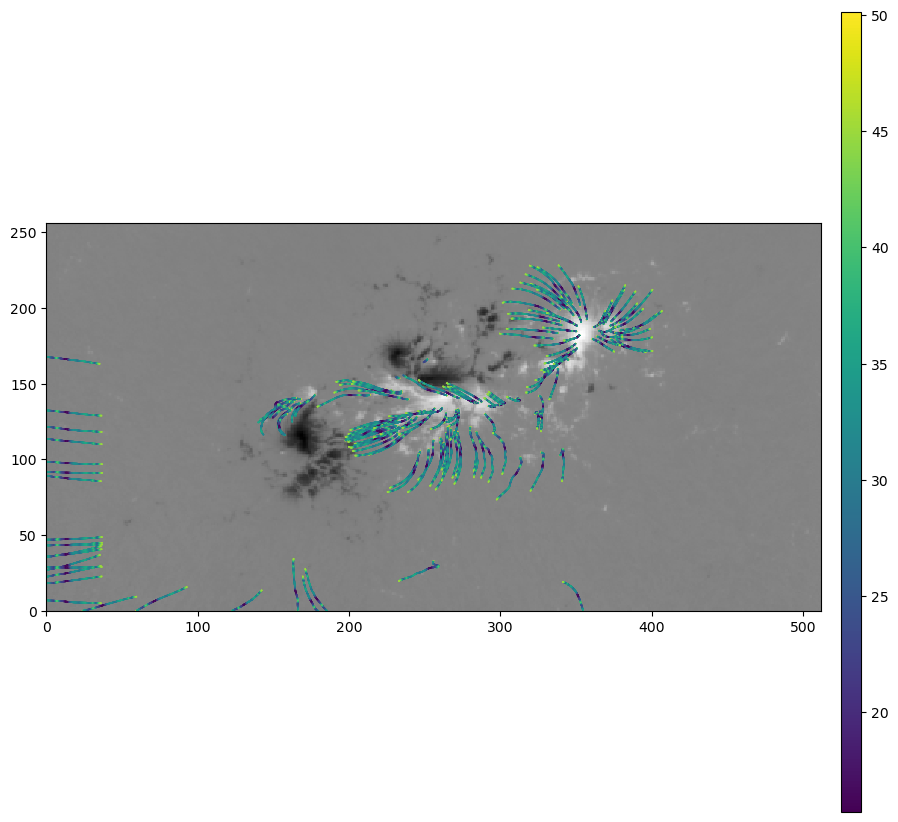

In [28]:
seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(b[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
# ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs:
    jj = js(xx)
    for k_i, k in enumerate(jj):
        ax.plot(xl[k_i:k_i+2, 0], xl[k_i:k_i+2, 1], color=s_map.to_rgba(k), linewidth=linesize)

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(s_map, cax=cax)
# palt.title("PINO")
plt.show()

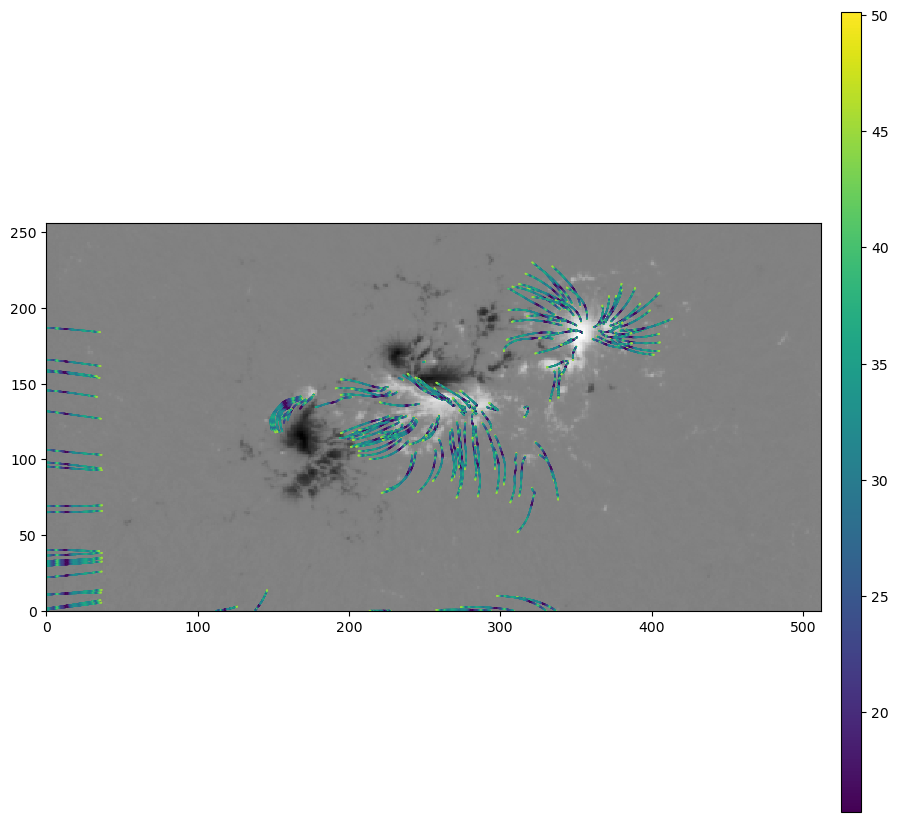

In [29]:
seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(B[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
# ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    jj = js(xx)
    for k_i, k in enumerate(jj):
        ax.plot(xl[k_i:k_i+2, 0], xl[k_i:k_i+2, 1], color=s_map.to_rgba(k), linewidth=linesize)

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
fig.colorbar(s_map, cax=cax)
# palt.title("PINO")
plt.show()

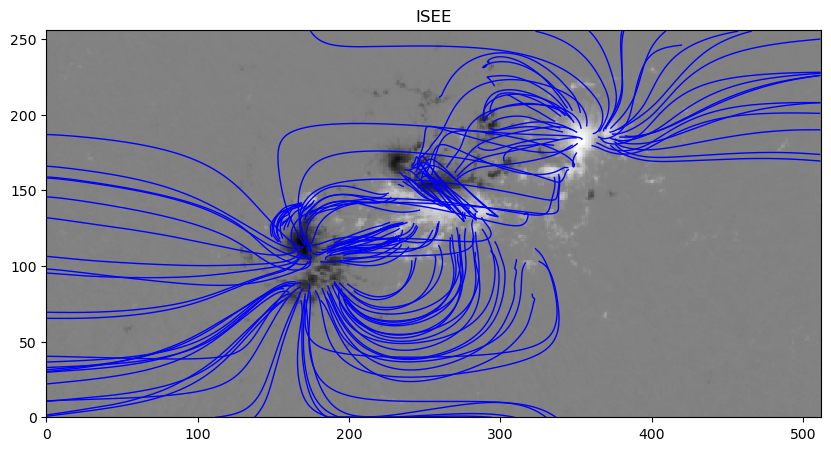

In [30]:
seedcolor = 'blue'
seedsize = 1
linecolor = 'blue'
linesize = 1

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.pcolor(B[..., 0, 2].T, cmap='gray')
ax.set_aspect('equal')
# ax.plot(seeds_xs[:, 0], seeds_xs[:, 1], 'o', color=seedcolor, markersize=seedsize)
for xl in tracer_xs_true:
    ax.plot(xl[:,0], xl[:,1], color=linecolor, linewidth=linesize)
plt.title("ISEE")
plt.show()

In [31]:
import pyvista as pv

In [32]:
j = vector_norm(curl(b))
j.shape

(512, 256, 256)

In [33]:
def create_coordinates(bounds):
    xbounds = (bounds[0], bounds[1])
    ybounds = (bounds[2], bounds[3])
    zbounds = (bounds[4], bounds[5])
    meshgrid = np.mgrid[xbounds[0]:xbounds[1]+1, ybounds[0]:ybounds[1]+1, zbounds[0]:zbounds[1]+1]
    return np.stack(meshgrid, axis=-1).astype(np.float32)


def create_mesh(bx, by, bz):
    bx, by, bz = map(np.array, (bx, by, bz))
    Nx, Ny, Nz = bx.shape
    co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    mesh = pv.StructuredGrid(x, y, z)
    vectors = np.stack([bx, by, bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['vector'] = vectors
    mesh.active_vectors_name = 'vector'
    magnitude = np.linalg.norm(vectors, axis=-1)
    mesh['magnitude'] = magnitude
    mesh.active_scalars_name = 'magnitude'

    j = curl(b)
    j_vec = np.stack([j[..., 0], j[..., 1], j[..., 2]], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['current'] = j_vec
    j_mag = np.linalg.norm(j_vec, axis=-1)
    mesh['current_magnitude'] = j_mag

    mesh['alpha'] = j_mag / magnitude

    return mesh

In [34]:
pv.set_jupyter_backend('static')

In [35]:
mesh = create_mesh(b[..., 0], b[..., 1], b[..., 2])

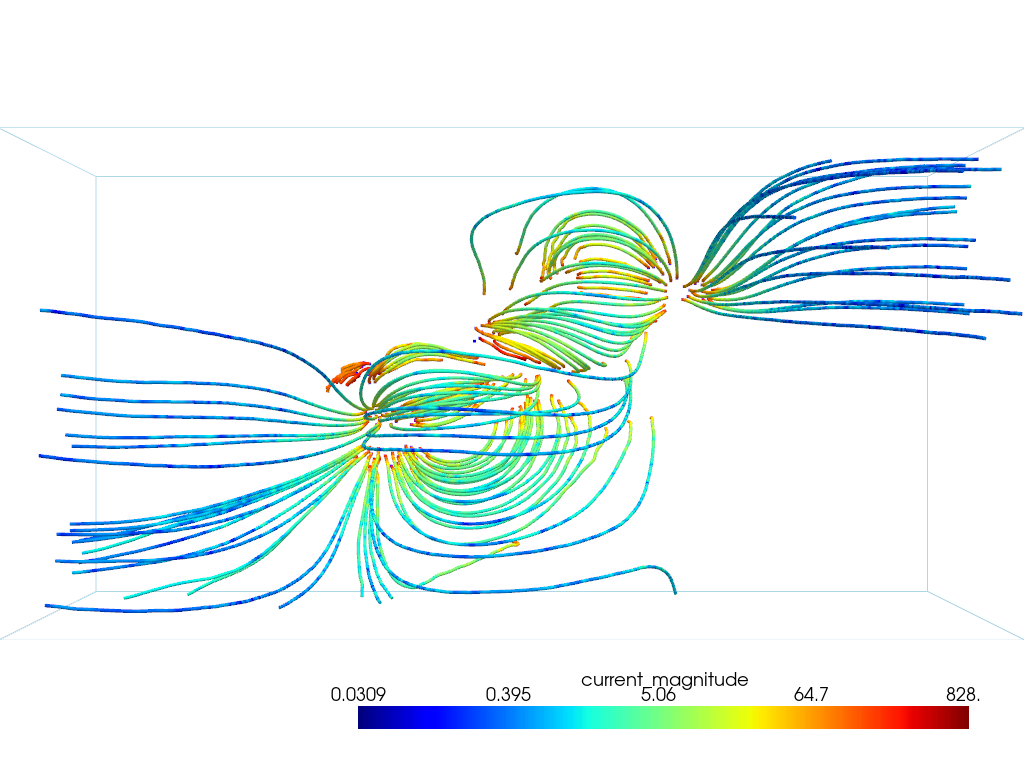

In [36]:
p = pv.Plotter()
p.add_mesh(mesh.outline())
seed = pv.PolyData(seeds_xs)
p.add_mesh(seed, color='blue', point_size=3)
strl = mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
p.add_mesh(strl.tube(radius=1), cmap='jet', ambient=0.2, scalars='current_magnitude', log_scale=True)
p.camera_position = "xy"
p.camera.zoom(1.5)
p.show()

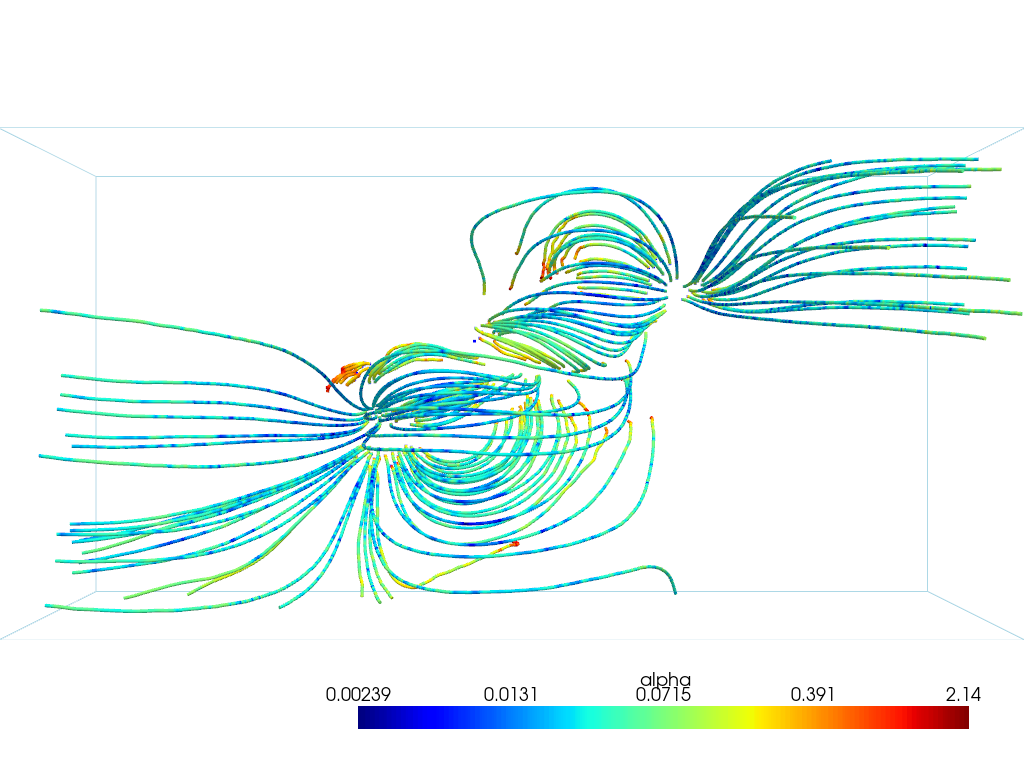

In [37]:
p = pv.Plotter()
p.add_mesh(mesh.outline())
seed = pv.PolyData(seeds_xs)
p.add_mesh(seed, color='blue', point_size=3)
strl = mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
p.add_mesh(strl.tube(radius=1), cmap='jet', ambient=0.2, scalars='alpha', log_scale=True)
p.camera_position = "xy"
p.camera.zoom(1.5)
p.show()

In [38]:
Mesh = create_mesh(B[..., 0], B[..., 1], B[..., 2])

In [ ]:
p = pv.Plotter()
p.add_mesh(Mesh.outline())
p.add_mesh()
seed = pv.PolyData(seeds_xs)
p.add_mesh(seed, color='blue', point_size=3)
strl = Mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
p.add_mesh(strl.tube(radius=1), cmap=pv.LookupTable(cmap='jet', scalar_range=(0, 100)), ambient=0.2, scalars='current_magnitude')
p.camera_position = "xy"
p.camera.zoom(1.5)
p.show()

In [ ]:
p = pv.Plotter()
p.add_mesh(Mesh.outline())
seed = pv.PolyData(seeds_xs)
p.add_mesh(seed, color='blue', point_size=3)
strl = Mesh.streamlines_from_source(seed,
                                    vectors='vector',
                                    max_time=10000,
                                    initial_step_length=0.1,
                                    integration_direction='both')
p.add_mesh(strl.tube(radius=1), cmap='jet', ambient=0.2, scalars='alpha', log_scale=True)
p.camera_position = "xy"
p.camera.zoom(1.5)
p.show()